/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)



********** Complete Dataset **********
  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

Number of rows and columns: (5572, 2)

********** Exploratory Data Analysis **********

Missing values in dataset:
 label    0
text     0
dtype: int64

Label distribution:
 label
ham     4825
spam     747
Name: count, dtype: int64


<ipython-input-1-4b41adcb0592>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="coolwarm")  # Coolwarm palette


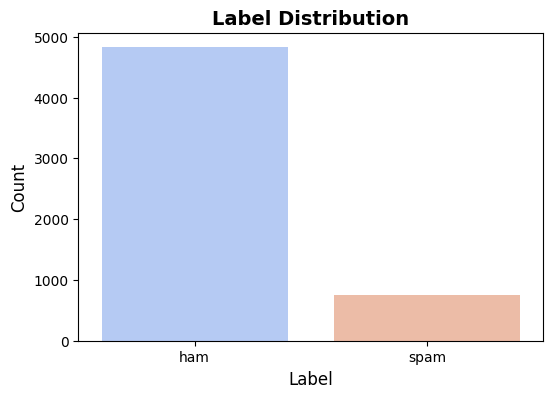

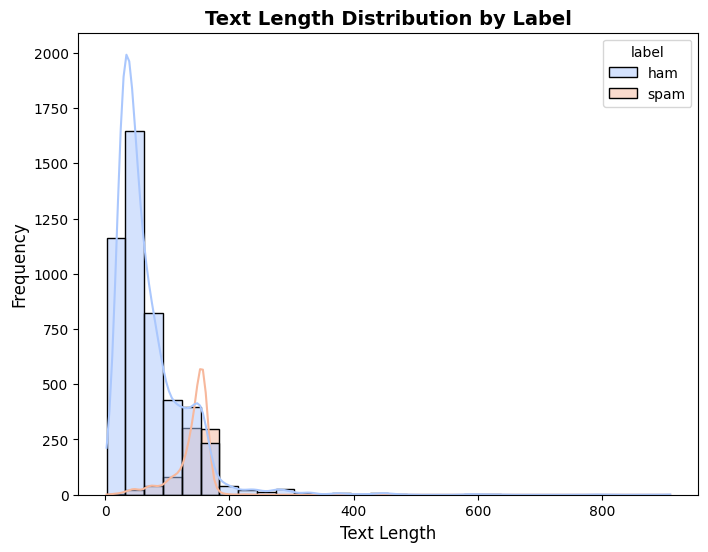


********** Naive Bayes **********
Accuracy of Naive Bayes: 97.22%

Classification Report for Naive Bayes:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       965
           1       1.00      0.79      0.88       150

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.93      1115
weighted avg       0.97      0.97      0.97      1115


********** SVM **********
Accuracy of SVM: 97.67%

Classification Report for SVM:

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       965
           1       0.99      0.83      0.91       150

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115


********** Random Forest **********
Accuracy of Random Forest: 97.85%

Classification Report for Random Forest:

              precision    recall  f1-sc

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import lightgbm as lgb  # Importing LightGBM

# Load dataset directly from the uploaded CSV file
file_path = 'spam.csv'  # Replace with your file name
try:
    data = pd.read_csv(file_path, encoding='latin1')  # Adjust encoding as needed
except UnicodeDecodeError:
    print("UnicodeDecodeError: Please ensure the file encoding matches (e.g., 'latin1', 'utf-8', etc.).")
    raise

# Rename columns for consistency and drop unnecessary ones
data = data.rename(columns={"v1": "label", "v2": "text"})
data = data[["label", "text"]]  # Keep only relevant columns

# Display the complete dataset
def display_dataset(df):
    print("\n\033[1;34m********** Complete Dataset **********\033[0m")
    print(df.head())  # Show the first few rows of the dataset
    print("\n\033[1;32mNumber of rows and columns:\033[0m", df.shape)

# Exploratory Data Analysis (EDA)
def perform_eda(df):
    print("\n\033[1;35m********** Exploratory Data Analysis **********\033[0m")
    print("\nMissing values in dataset:\n", df.isnull().sum())

    # Label distribution
    label_counts = df['label'].value_counts()
    print("\n\033[1;36mLabel distribution:\033[0m\n", label_counts)
    plt.figure(figsize=(6, 4))
    sns.barplot(x=label_counts.index, y=label_counts.values, palette="coolwarm")  # Coolwarm palette
    plt.title("Label Distribution", fontsize=14, fontweight='bold')
    plt.xlabel("Label", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.show()

    # Text length analysis
    df['text_length'] = df['text'].apply(len)
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df, x='text_length', hue='label', bins=30, kde=True, palette="coolwarm")
    plt.title("Text Length Distribution by Label", fontsize=14, fontweight='bold')
    plt.xlabel("Text Length", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.show()

# Perform EDA
display_dataset(data)
perform_eda(data)

# Step 1: Preprocessing with Pipeline
label_encoder = LabelEncoder()
def preprocess_labels(df):
    df['label'] = label_encoder.fit_transform(df['label'])  # Convert labels to binary (0 = ham, 1 = spam)
    return df

# Text preprocessing
def preprocess_text(df):
    return df['text']

# Define transformers
label_transformer = FunctionTransformer(preprocess_labels)
text_transformer = FunctionTransformer(preprocess_text)

# ColumnTransformer for EDA and Preprocessing
preprocessor = ColumnTransformer([
    ('label_preprocessor', label_transformer, ['label']),
    ('text_preprocessor', text_transformer, 'text')
])

# Apply preprocessing pipeline
data = preprocess_labels(data)

# Step 2: Split data into training and testing sets
X = data['text']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Feature extraction using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Step 4: Define the models
models = {
    "Naive Bayes": MultinomialNB(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "LightGBM": lgb.LGBMClassifier()  # Adding LightGBM model
}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"\n\033[1;35m********** {model_name} **********\033[0m")  # Heading for each model
    model.fit(X_train_tfidf, y_train)
    predictions = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, predictions)
    report = classification_report(y_test, predictions)

    # Color the output of the classification report
    print(f"Accuracy of {model_name}: \033[1;32m{accuracy * 100:.2f}%\033[0m")
    print(f"\n\033[1;33mClassification Report for {model_name}:\033[0m\n")
    print("\033[1;34m" + report + "\033[0m")  # Blue color for classification report

# Function to classify user input as spam or ham
def classify_message(message, model, vectorizer):
    # Preprocess the input message
    message_tfidf = vectorizer.transform([message])  # Convert the input message to TF-IDF features
    prediction = model.predict(message_tfidf)  # Predict the label (0 = ham, 1 = spam)

    # Convert the prediction back to the original label
    label = 'spam' if prediction[0] == 1 else 'ham'

    return label

# Expanded: Get user input, classify, and loop until the user decides to stop
def interactive_classification():
    print("\n\033[1;35mWelcome to the Spam/Ham message classifier!\033[0m")  # Magenta color for the welcome message

    # Let the user choose the model
    model_choice = input("\033[1;33mChoose a model: Naive Bayes, SVM, Random Forest, Decision Tree, LightGBM: \033[0m").strip()

    # Validate model choice
    if model_choice not in models:
        print("\033[1;31mInvalid model choice. Using Naive Bayes by default.\033[0m")  # Red for invalid input
        model_choice = "Naive Bayes"

    model = models[model_choice]

    while True:
        user_message = input("\n\033[1;36mEnter a message to classify as spam or ham (or type 'exit' to quit): \033[0m")

        if user_message.lower() == 'exit':
            print("\033[1;32mExiting the classifier. Goodbye!\033[0m")  # Green color for exit
            break

        classification = classify_message(user_message, model, vectorizer)
        print(f"\033[1;33mThe message is classified as: {classification}\033[0m")  # Yellow for classification result

# Run the interactive classification function
interactive_classification()
